<a href="https://colab.research.google.com/github/mashaan14/VisionTransformer-MNIST/blob/main/VisionTransformer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing attention maps in MNIST vision transformer
This notebook is designed to plot the attention maps of a vision transformer trained on MNIST digits. Looking at the attached gif, the neural net knows where to “pay attention”.

I've looked at multiple resources, but these were particularly useful:
  - https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html
  - https://medium.com/@hirotoschwert/an-unofficial-colab-walkthrough-of-vision-transformer-8bcd592ba26a
  - https://storrs.io/attention-rollout/
  - https://jacobgil.github.io/deeplearning/vision-transformer-explainability

## References:
```bibtex
@misc{dosovitskiy2021image,
  title         = {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
  author        = {Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby},
  year          ={2021},
  eprint        = {2010.11929},
  archivePrefix = {arXiv},
  primaryClass  = {cs.CV}
}
```

## Import libraries

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

## Setting some parameters

In [2]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading MNIST from torchvision

In [3]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1391065.24it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 56355.55it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 244890.56it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9468453.66it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 934498.86it/s] 


Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 130991.07it/s]


Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1045032.99it/s]


Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10225726.66it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



In [4]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


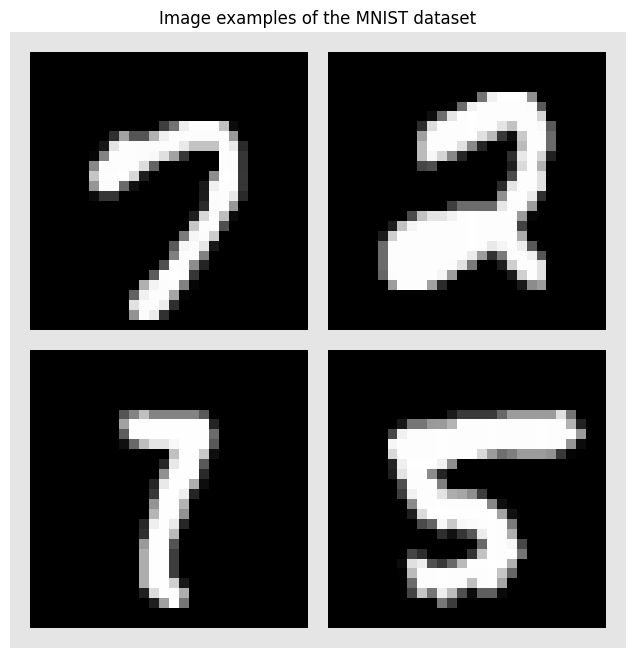

In [5]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Visualizing `img_to_patch` function

In [7]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

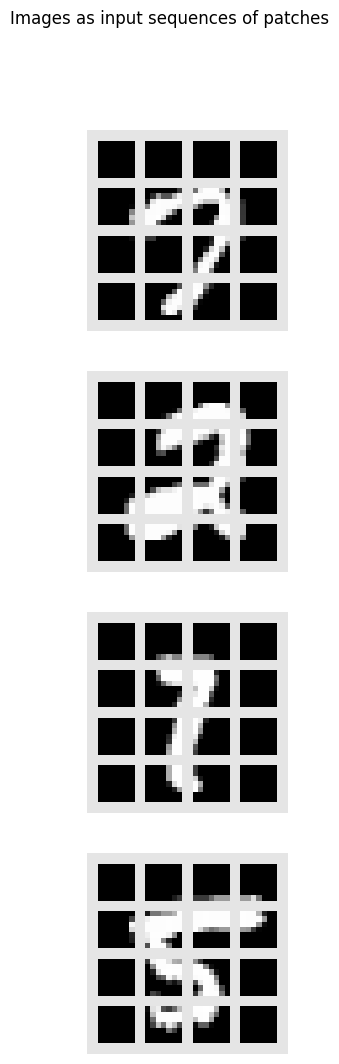

In [8]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

## VisionTransformer class

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [10]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## Initializing the model

In [11]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [12]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

## Training

In [13]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1910 valid 0.1468


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0558 valid 0.1268


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2644 valid 0.1166


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0810 valid 0.1030


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0195 valid 0.0862


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0021 valid 0.0860


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0056 valid 0.0760


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0068 valid 0.0986


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0107 valid 0.0727


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1085 valid 0.0845


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0048 valid 0.0806


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0079 valid 0.0738


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1293 valid 0.0718


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0154 valid 0.0831


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0013 valid 0.0708


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0003 valid 0.0684


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0215 valid 0.0651


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0007 valid 0.0709


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0096 valid 0.0639


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0031 valid 0.0619


Text(0.5, 1.0, 'Training loss')

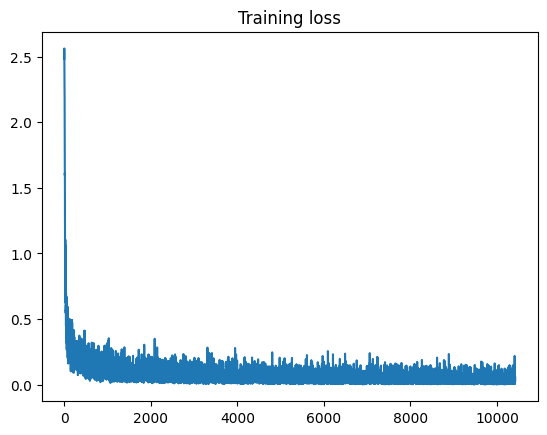

In [14]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [15]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.9816


## Picking one test sample and running it through the first attention block

In [33]:
test_sample_index = (test_set.targets==7).nonzero(as_tuple=True)[0][5].item()

In [34]:
# pull out one test sample
img_tensor = test_set.data[test_sample_index].to(device)
# convert the test sample into patches
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
# run the patches through the input layer to get a tensor of size embed_dim
patches = model.input_layer(patches.float())
# attach the class token and add the position embedding
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
print("Input tensor to Transformer: ", transformer_input.shape)
# run the embedded test image through the first attention block and squeeze the
# batch dimension because we're only using one test image
transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
print("transformer_input_expanded shape: ", transformer_input_expanded.shape)

Input tensor to Transformer:  torch.Size([1, 17, 256])
transformer_input_expanded shape:  torch.Size([17, 768])


In [35]:
# reshape the output of the first attention block to be of size (num_patches+1, 3, num_heads, -1)
qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, -1)
print("qkv shape: ", qkv.shape)
# pull the query matrix and permute the dimensions to be (8 heads, 17 patches, 32 channels)
# do the same for the key matrix
q = qkv[:, 0].permute(1, 0, 2)
k = qkv[:, 1].permute(1, 0, 2)
print("q shape: ", q.shape)
print("k shape: ", k.shape)
kT = k.permute(0, 2, 1)
# The result of multiplying q @ kT is a squared matrix 17 by 17 showing how each
# patch is "paying attention" to every other patch
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)

qkv shape:  torch.Size([17, 3, 8, 32])
q shape:  torch.Size([8, 17, 32])
k shape:  torch.Size([8, 17, 32])
attention matrix:  torch.Size([8, 17, 17])


In [40]:
# Average the attention weights across all heads by taking the mean along
# the first dimension
attention_matrix_mean = torch.mean(attention_matrix, dim=0)
print("attention matrix mean: ", attention_matrix_mean.shape)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
# Please refer to the attention rollout paper: https://arxiv.org/abs/2005.00928
residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
aug_att_mat = attention_matrix_mean + residual_att
print("augmented attention matrix: ", aug_att_mat.shape)
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print("normalized augmented attention matrix: ", aug_att_mat.shape)

attention matrix mean:  torch.Size([17, 17])
augmented attention matrix:  torch.Size([17, 17])
normalized augmented attention matrix:  torch.Size([17, 17])


## Plotting attention
Now we have a normalized squared matrix of size $17\times 17$. When plotting the first column is the class token. The remaining $16$ columns will be reshaped into a $4\times 4$ matrix, ordered in a way where each patch has its position in the image. For better visualization, we'll use `interpolate` function to resize the $4\times 4$ matrix to $28\times 28$.

attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


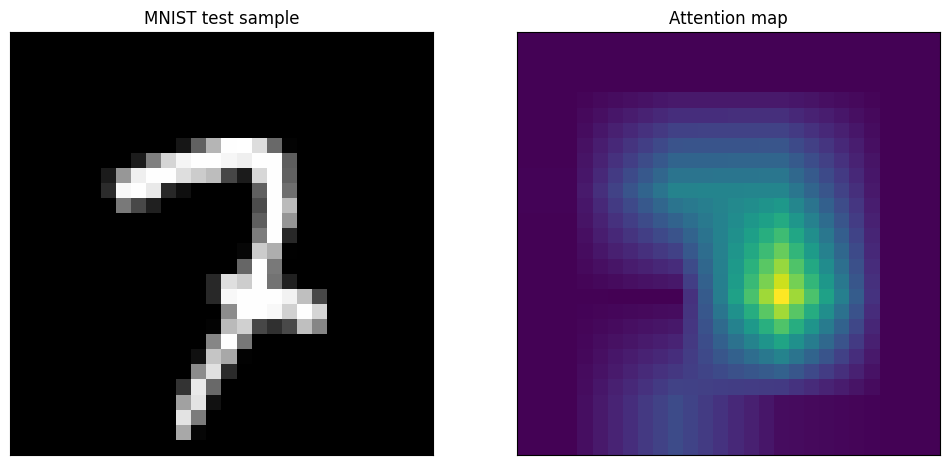

In [43]:
attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('Attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)